# Csgo Data

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# import psycopg2
import scipy.stats
from collections import Counter

# conn = psycopg2.connect(database="test", user="postgres", password="0000", host="localhost", port="5432")

### Cleaning Data

In [3]:
df = pd.read_csv('profiles.csv')
df.head(1)

,user_id,nickname,total_kills,total_deaths,total_time_played,total_kills_headshot,total_shots_hit,total_mvps,total_wins,total_rounds_played,total_shots_fired,rank_id,goal_id,steam_id,about,updated_at,compensation
0,1,s1rc0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,NaN,NaN,NaN,NaN


In [4]:
# Drop values that shouldn't be NaN for normal players
df = df.dropna(subset=['total_kills','total_deaths','total_time_played','total_rounds_played',
                                             'total_shots_fired'])
# Fill NaN
df.fillna(0, inplace=True)

# Add Kill Death Ratio
df['kill_death_ratio'] = df['total_kills'].div(df['total_deaths'] ,axis='index')

# Exclude unreasonable data
df = df[(df['total_time_played'] != 0) & (df['total_shots_fired'] != 0) & (df['total_deaths'] != 0) & (df['total_kills'] != 0) &
        (df['total_shots_fired']>df['total_kills']) & (df['total_kills_headshot']<df['total_kills']) &  
        (df['total_time_played'] <= 1963*12*60*60) & (df['total_mvps']<df['total_rounds_played']) & 
        (df['total_deaths']<1963*12*30) & (df['total_kills']<df['total_rounds_played']*9) & (df['kill_death_ratio']<=15)]

# Game released in 21Aug2013, the latest updated profile in data is 5Jan2018, game hours played should not exceed 1963 days
# Total MVP should be less than total rounds played
# Max game round per hour is 30, total death should not exceed 1963days*12hour*30rounds
# Exclude more than 9 kills per round
# Exclude Kill Death ratio exceed 15

df.shape

(75408, 18)

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75408 entries, 5 to 84391
Data columns (total 18 columns):
user_id                 75408 non-null int64
nickname                75408 non-null object
total_kills             75408 non-null float64
total_deaths            75408 non-null float64
total_time_played       75408 non-null float64
total_kills_headshot    75408 non-null float64
total_shots_hit         75408 non-null float64
total_mvps              75408 non-null float64
total_wins              75408 non-null float64
total_rounds_played     75408 non-null float64
total_shots_fired       75408 non-null float64
rank_id                 75408 non-null int64
goal_id                 75408 non-null int64
steam_id                75408 non-null float64
about                   75408 non-null object
updated_at              75408 non-null datetime64[ns, UTC]
compensation            75408 non-null float64
kill_death_ratio        75408 non-null float64
dtypes: datetime64[ns, UTC](1), float64(1

In [5]:
df.head(20)

,user_id,nickname,total_kills,total_deaths,total_time_played,total_kills_headshot,total_shots_hit,total_mvps,total_wins,total_rounds_played,total_shots_fired,rank_id,goal_id,steam_id,about,updated_at,compensation,kill_death_ratio
5,145,Eugene,1.0,9.0,1216.0,0.0,8.0,0.0,2.0,16.0,11.0,1,1,7.656120e+16,0,2017-12-09 03:10:28.514889+00:00,0.0,0.111111
8,216,Rz-Baron,47887.0,60368.0,4726211.0,14766.0,148706.0,3122.0,22932.0,45169.0,844161.0,11,1,7.656120e+16,0,2017-12-09 03:10:28.803997+00:00,0.0,0.793251
10,154,dreamteam.gg,310.0,344.0,9229.0,85.0,1604.0,0.0,28.0,51.0,9192.0,1,3,7.656120e+16,0,2017-12-09 03:10:28.940558+00:00,0.0,0.901163
11,187,FuN1111,82.0,110.0,10472.0,24.0,335.0,9.0,44.0,80.0,3124.0,1,1,7.656120e+16,0,2017-12-09 03:10:29.118630+00:00,0.0,0.745455
13,176,KhinShen,104506.0,134275.0,2510854.0,31266.0,91449.0,2743.0,8728.0,18005.0,420633.0,8,1,7.656120e+16,0,2017-12-09 03:10:30.121044+00:00,0.0,0.778298
14,219,NiFall,42387.0,28211.0,2064934.0,14573.0,139742.0,4814.0,15685.0,27894.0,837688.0,8,2,7.656120e+16,0,2017-12-09 03:10:30.309070+00:00,0.0,1.502499
16,189,adzuma,45239.0,36772.0,3349786.0,18167.0,139443.0,6655.0,24288.0,47078.0,726799.0,16,3,7.656120e+16,0,2017-12-09 03:10:30.614950+00:00,0.0,1.230257
17,183,Ablaze,9687.0,9284.0,723996.0,3683.0,32367.0,1169.0,5194.0,9939.0,187014.0,18,3,7.656120e+16,Top player EU,2017-12-09 03:10:30.795407+00:00,0.0,1.043408
18,185,amillern,303.0,147.0,15628.0,125.0,1043.0,48.0,117.0,206.0,4972.0,1,1,7.656120e+16,0,2017-12-09 03:10:31.045224+00:00,0.0,2.061224
20,194,JcK,24826.0,24588.0,1430353.0,11942.0,69276.0,6702.0,16905.0,32009.0,392248.0,13,2,7.656120e+16,0,2017-12-09 03:10:31.290241+00:00,0.0,1.009680


In [6]:
df.describe()

,user_id,total_kills,total_deaths,total_time_played,total_kills_headshot,total_shots_hit,total_mvps,total_wins,total_rounds_played,total_shots_fired,rank_id,goal_id,steam_id,compensation,kill_death_ratio
count,75408.000000,7.540800e+04,75408.000000,7.540800e+04,7.540800e+04,7.540800e+04,75408.000000,7.540800e+04,7.540800e+04,7.540800e+04,75408.000000,75408.000000,7.540800e+04,75408.0,75408.000000
mean,51869.860559,3.347832e+04,31583.216993,2.000750e+06,1.328896e+04,1.245550e+05,3498.330548,1.367331e+04,2.755515e+04,5.827236e+05,10.850732,2.335203,7.655308e+16,0.0,1.098469
std,29092.146217,3.574802e+04,33307.778140,1.992659e+06,1.784226e+04,5.476255e+06,4302.663910,1.380116e+04,2.083728e+05,7.239360e+06,4.738698,0.771422,7.885420e+14,0.0,0.458218
min,2.000000,1.000000e+00,1.000000,8.700000e+01,0.000000e+00,5.000000e+00,0.000000,0.000000e+00,2.000000e+00,1.100000e+01,1.000000,1.000000,0.000000e+00,0.0,0.000675
25%,27073.750000,1.065400e+04,9947.750000,6.593285e+05,3.403000e+03,3.323775e+04,1055.000000,4.663000e+03,8.825750e+03,1.809772e+05,7.000000,2.000000,7.656120e+16,0.0,0.913980
50%,51996.500000,2.359700e+04,22574.000000,1.492532e+06,8.238000e+03,7.547700e+04,2482.000000,1.030500e+04,2.018100e+04,4.110340e+05,11.000000,3.000000,7.656120e+16,0.0,1.037991
75%,76996.250000,4.491500e+04,42416.000000,2.783598e+06,1.696025e+04,1.402945e+05,4801.000000,1.912125e+04,3.770650e+04,7.621885e+05,15.000000,3.000000,7.656120e+16,0.0,1.180294
max,102075.000000,1.103536e+06,640459.000000,7.332304e+07,1.001366e+06,1.500003e+09,681118.000000,1.306899e+06,5.677531e+07,1.980065e+09,18.000000,3.000000,7.656120e+16,0.0,13.111460


### Plot - Total Kills / Total Deaths  

In [13]:
max(df.total_deaths)

640459.0

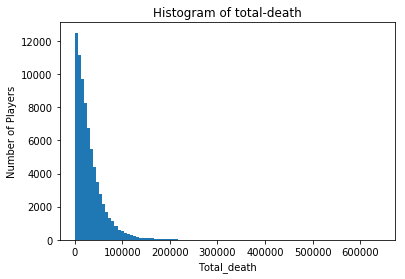

In [12]:
%matplotlib inline
total_death = df.total_deaths
plt.hist(total_death,bins=100)
plt.xlabel('Total_death')
plt.ylabel('Number of Players')
plt.title('Histogram of total-death')
plt.show()

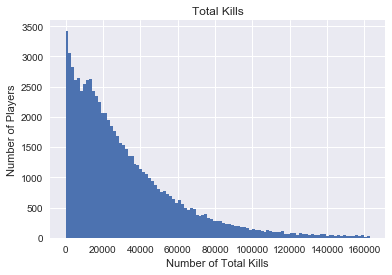

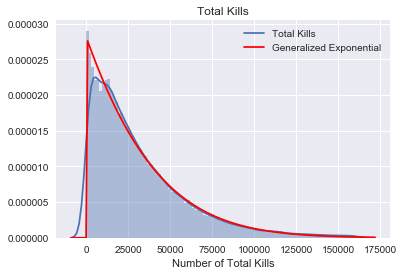

Total Kills
median: 23597.0
mean: 33478.31820231275
mode: ModeResult(mode=array([ 2040.]), count=array([13]))
minimum value: 1
maximum value: 1103536
Standard deviation: 35748.0217244977
kurtosis: 42.513558370510474
Skewness: 3.9151436124505197
quantile 99% value: 162988.9799999994
quantile 90% value: 73129.6
quantile 75% value: 44915.0
quantile 50% value: 23597.0
quantile 25% value: 10654.0

Genexpon: KstestResult(statistic=0.011798484795887632, pvalue=1.5252919479399381e-09)
Expon: KstestResult(statistic=0.022923064493149098, pvalue=7.6508105235188851e-35)



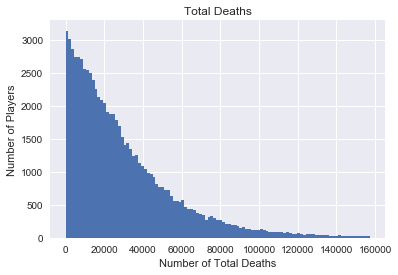

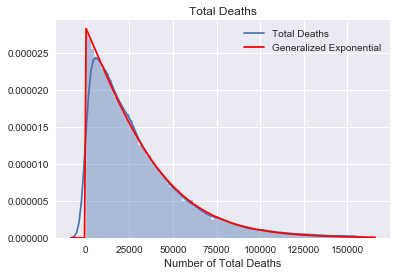

Total Deaths
median: 22574.0
mean: 31583.216992892
mode: ModeResult(mode=array([ 2024.]), count=array([11]))
minimum value: 1
maximum value: 640459
Standard deviation: 33307.77813961288
kurtosis: 24.556979886938826
Skewness: 3.4028618870948444
quantile 99% value: 157365.8999999998
quantile 90% value: 68652.0
quantile 75% value: 42416.0
quantile 50% value: 22574.0
quantile 25% value: 9947.75

Genexpon: KstestResult(statistic=0.021180872246028271, pvalue=8.2500235602305997e-30)
Expon: KstestResult(statistic=0.021191112297753778, pvalue=7.7274452027610129e-30)



In [7]:
cols = ['total_kills', 'total_deaths']
col_names = ['Total Kills', 'Total Deaths']

sns.set()
for col_names, cols in zip(col_names, cols):
       
    q = df[cols].quantile(.99)
    i = df.loc[df[cols] <= q][cols]  
    plt1 = plt.hist(i,bins='auto')
    plt.title(col_names)
    plt.xlabel('Number of '+col_names)
    plt.ylabel('Number of Players')
    plt.show(plt1)
    
    plt2 = sns.distplot(i, bins='auto',kde = True, fit = scipy.stats.genexpon,
                        kde_kws={"label": col_names}, fit_kws={"color": "r", "alpha": 1, "label": "Generalized Exponential"})
    plt.title(col_names)
    plt.xlabel('Number of '+col_names)
    plt.legend(loc='best', frameon=False)
    plt.show(plt2)
    
    print(col_names)
    print('median: '+ str(np.median(df[cols])))
    print('mean: '+ str(np.mean(df[cols])))
    print('mode: '+ str(scipy.stats.mode(df[cols])))
    print('minimum value: '+str(int(min(df[cols]))))
    print('maximum value: '+str(int(max(df[cols]))))
    print('Standard deviation: '+str(pd.DataFrame.std(df[cols])))
    print('kurtosis: '+str(scipy.stats.kurtosis(df[cols])))
    print('Skewness: '+str(scipy.stats.skew(df[cols])))
    print('quantile 99% value: '+ str(df[cols].quantile(.99)))
    print('quantile 90% value: '+ str(df[cols].quantile(.90)))
    print('quantile 75% value: '+ str(df[cols].quantile(.75)))
    print('quantile 50% value: '+ str(df[cols].quantile(.50)))
    print('quantile 25% value: '+ str(df[cols].quantile(.25)))
    print('')
    data = np.sort(df[cols])
    test = scipy.stats.genexpon.fit(data)
    test2 = scipy.stats.expon.fit(data)
    print('Genexpon: '+str(scipy.stats.kstest(data, cdf='genexpon', args=test)))
    print('Expon: '+str(scipy.stats.kstest(data, cdf='expon', args=test2)))
    print('')


### Log Plot - Total Kills / Total Deaths

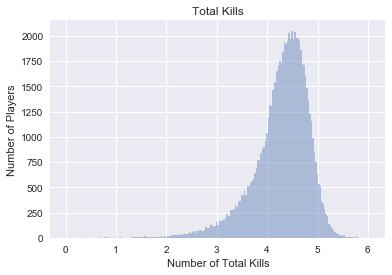

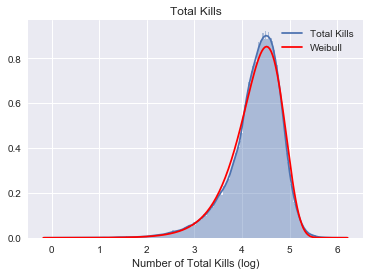

Total Kills
median: 4.37285679254
mean: 4.282203896766928
mode: ModeResult(mode=array([ 3.30963017]), count=array([13]))
minimum value: 0
maximum value: 6
Standard deviation: 0.5471903780549796
kurtosis: 2.854242507416484
Skewness: -1.2308955053836705
quantile 75% value: 4.652391404017054
quantile 50% value: 4.372856792535229
quantile 25% value: 4.027512692448811

KstestResult(statistic=0.020011171060799082, pvalue=1.1812223468355686e-26)



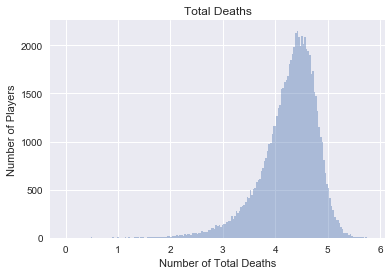

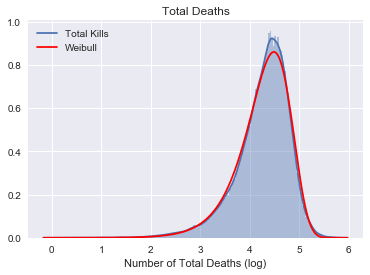

Total Deaths
median: 4.35360852071
mean: 4.262156838930793
mode: ModeResult(mode=array([ 3.30621051]), count=array([11]))
minimum value: 0
maximum value: 5
Standard deviation: 0.5375265123661614
kurtosis: 2.781249100889908
Skewness: -1.19857530593878
quantile 75% value: 4.627529710389018
quantile 50% value: 4.353608520708639
quantile 25% value: 3.9977248619338552

KstestResult(statistic=0.015376814151234319, pvalue=6.5182528931441188e-16)



In [8]:
cols = ['total_kills', 'total_deaths']
col_names = ['Total Kills', 'Total Deaths']


sns.set()
for col_names, cols in zip(col_names, cols):
    
    i=np.log10(df[cols])
    plt1 = sns.distplot(i, bins='auto', kde = False)
    plt.title(col_names)
    plt.xlabel('Number of '+col_names)
    plt.ylabel('Number of Players')
    plt.show(plt1)
        
    plt2 = sns.distplot(i, bins='auto', kde = True, fit = scipy.stats.weibull_min, 
                        kde_kws={"label": "Total Kills"}, fit_kws={"color": "r", "alpha": 1, "label": "Weibull"})
    plt.title(col_names)
    plt.xlabel('Number of '+col_names+' (log)')
    plt.legend(loc='best', frameon=False)
    plt.show(plt2)
    
    print(col_names)
    print('median: '+ str(np.median(i)))
    print('mean: '+ str(np.mean(i)))
    print('mode: '+ str(scipy.stats.mode(i)))
    print('minimum value: '+str(int(min(i))))
    print('maximum value: '+str(int(max(i))))
    print('Standard deviation: '+str(pd.DataFrame.std(i)))
    print('kurtosis: '+str(scipy.stats.kurtosis(i)))
    print('Skewness: '+str(scipy.stats.skew(i)))
    print('quantile 75% value: '+ str(i.quantile(.75)))
    print('quantile 50% value: '+ str(i.quantile(.50)))
    print('quantile 25% value: '+ str(i.quantile(.25)))
    print('')
    data = np.sort(i)
    test = scipy.stats.weibull_min.fit(data)
    print(scipy.stats.kstest(data, cdf='weibull_min', args=test))
    print('')

### Rank/frequency plot - Total Kills / Total Deaths

In [ ]:
ks = np.flip(np.sort(df['total_kills']), axis=0)
data_sorted = np.sort(ks)




In [28]:
ks = np.flip(np.sort(df['total_kills']), axis=0)
data_sorted = np.sort(ks)

ks_values = []
for clip_count in range(1, 8000):
    clipped_data = data_sorted[:-clip_count]
    
    params = scipy.stats.expon.fit(clipped_data)
    kst = scipy.stats.kstest(clipped_data, 'expon', params)
    
    ks_values.append((clip_count, kst))
        
    if clip_count % 100 == 0:
        print('Finished iteration %i, %s' %(clip_count, kst))

Finished iteration 100, KstestResult(statistic=0.99814741615838054, pvalue=0.0)
Finished iteration 200, KstestResult(statistic=0.027816130915443882, pvalue=5.711841109131777e-51)
Finished iteration 300, KstestResult(statistic=0.15956523266498379, pvalue=0.0)
Finished iteration 400, KstestResult(statistic=0.030645917050701688, pvalue=1.2968993701657053e-61)
Finished iteration 500, KstestResult(statistic=0.032087609719397503, pvalue=2.041312309175078e-67)
Finished iteration 600, KstestResult(statistic=0.89129670260821259, pvalue=0.0)
Finished iteration 700, KstestResult(statistic=0.89118252887604787, pvalue=0.0)
Finished iteration 800, KstestResult(statistic=0.89106804894335057, pvalue=0.0)
Finished iteration 900, KstestResult(statistic=0.89095326106405337, pvalue=0.0)
Finished iteration 1000, KstestResult(statistic=0.89083816478637934, pvalue=0.0)
Finished iteration 1100, KstestResult(statistic=0.89072275869361472, pvalue=0.0)
Finished iteration 1200, KstestResult(statistic=0.0393013866

KeyboardInterrupt: 

In [29]:
ks_min = sorted(ks_values, key=lambda x: x[1].statistic)[0]
print('KS minimum: %i, %f' %(ks_min[0], ks_min[1].statistic))

KS minimum: 256, 0.021504


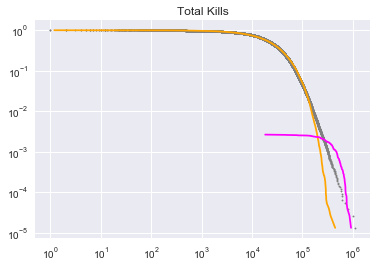

In [20]:
cols = ['total_kills']
col_names = ['Total Kills']


sns.set()
for col_names, cols in zip(col_names, cols):
       
    data_sorted = np.sort(df[cols])
    rank = np.flip(np.arange(1, len(data_sorted) + 1), axis=0) / (len(data_sorted) + 1)

    # Setup plot
    fig = plt.figure(1)
    ax = fig.add_subplot(1, 1, 1, label='plot6')

    # Plot points
    plt.scatter(data_sorted, rank, color='gray', s=2)

    # Plot exponential
    params = scipy.stats.expon.fit(data_sorted)
    x_axis = np.sort(scipy.stats.expon.rvs(*params, len(rank)))
    plt.plot(x_axis, rank, color='orange')
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    # Plot tail
    clip_start = 200

    lin_data = data_sorted[-clip_start:]
    lin_rank = rank[-clip_start:]

    params = scipy.stats.chi2.fit(lin_data)
    x_axis = np.sort(scipy.stats.chi2.rvs(*params, len(lin_rank)))

    plt.plot(x_axis, lin_rank, color='fuchsia')
    plt.title(col_names)

#     plt.legend(['fit-body', 'fit-tail', 'original data'])
    plt.show()

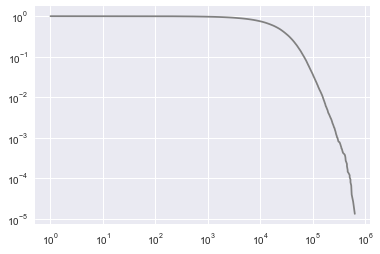

In [21]:
sns.set()
       
data_sorted = np.sort(df['total_deaths'])
rank = np.flip(np.arange(1, len(data_sorted) + 1), axis=0) / (len(data_sorted) + 1)

# Setup plot
fig = plt.figure(1)
ax = fig.add_subplot(1, 1, 1, label='plot6')

# Plot points
plt.loglog(data_sorted, rank, color='gray')

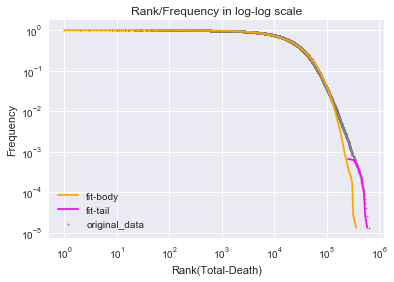

In [25]:
sns.set()
       
data_sorted = np.sort(df['total_deaths'])
rank = np.flip(np.arange(1, len(data_sorted) + 1), axis=0) / (len(data_sorted) + 1)

# Setup plot
fig = plt.figure(1)
ax = fig.add_subplot(1, 1, 1, label='plot6')

# Plot points
plt.scatter(data_sorted, rank, color='gray', s=2)

# Plot exponential
params = scipy.stats.expon.fit(data_sorted)
x_axis = np.sort(scipy.stats.expon.rvs(*params, len(rank)))
plt.plot(x_axis, rank, color='orange')
ax.set_xscale('log')
ax.set_yscale('log')
    
# Plot tail
clip_start = 50

lin_data = data_sorted[-clip_start:]
lin_rank = rank[-clip_start:]

params = scipy.stats.chi2.fit(lin_data)
x_axis = np.sort(scipy.stats.chi2.rvs(*params, len(lin_rank)))

plt.plot(x_axis, lin_rank, color='fuchsia')
plt.title('Rank/Frequency in log-log scale')
plt.xlabel('Rank(Total-Death)')
plt.ylabel('Frequency')
plt.legend(['fit-body', 'fit-tail', 'original_data'])
plt.show()

In [27]:
clipped_data = data_sorted[:-50]
    
params = scipy.stats.expon.fit(clipped_data)
kst = scipy.stats.kstest(clipped_data, 'expon', params)
kst

KstestResult(statistic=0.023034394878906073, pvalue=3.729318998954587e-35)